<a href="https://colab.research.google.com/github/AlirezaAbedinii/ImageCaptioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-hu6_porj
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-hu6_porj
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312215 sha256=a51d098c2b27b6b2a52a227664bd6d983aff8b3301e1ed13203a858ae3da5712
  Stored in directory: /tmp/pip-ephem-wheel-cache-an2arnat/wheels/6f/c9/51/e266f0496048c16686e133d8e33644d692931a356bfb372aae
Successfully built pycocoevalcap


In [2]:
!pip install --upgrade bleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5801 sha256=b4613226675d82546641b67cfa68f31c133ecc788fcc69909193439677decbaa
  Stored in directory: /root/.cache/pip/wheels/90/95/f7/3b9dd43fae308b83b018fb3c1b8647d622b3401c23a7ebc41e
  Created wheel for efficiency: filename=efficiency-1.1-py3-none-any.whl size=22158 sha256=09867a5aef98872f56a6226f1c0c3e00405ccee57bb84507b610e9b46691f0af
  Stored in directory: /root/.cache/pip/wheels/eb/c2/8e/2bc261126dcc968d98baacf12e6af4108e78652c9e7c85ea7c
Successfully built bleu efficiency


# Imports

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import zipfile
from tensorflow.keras.applications.resnet50 import ResNet50
import re
import tqdm
import pickle
from bleu import list_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.util import ngrams
from nltk.translate.bleu_score import SmoothingFunction

In [4]:
from collections import defaultdict
import json
import time
import itertools
import os, os.path
import math

In [5]:
%matplotlib inline 
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import random
from shutil import copyfile
import cv2
import time
from PIL import Image

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

In [7]:
from gym import Env
from gym import spaces

In [8]:
tref = ['a man climbing a mountain', 
 'a man climbs a mountain',
 'a man is climbing a side of a mountain',
 'a shirtless man climbs up a steep mountain',
 'a young white man is climbing a mountain with a rope as a guide']
 
hyp = 'a man climbs a cliff face'
sentence_bleu(tref, hyp) 

0.6342834010525136

# Globals

## Variables

In [9]:
dataDir='/content/drive/MyDrive/Dataset/annotations_trainval2017.zip (Unzipped Files)'
dataType='val2017'
pictures_dir_path = "/content/drive/MyDrive/Dataset/val2017.zip (Unzipped Files)/val2017"
train_dir_path = "/content/drive/MyDrive/Dataset/Train"
test_dir_path = "/content/drive/MyDrive/Dataset/Test"
global_images_ids = []
global_data = []
global_test_data = []
global_train_data = []
train_pics = []
test_pics = []
dataset = pd.DataFrame(columns = ['id', 'is_training' 'r', 'g', 'b',
                                  'captions', 'url'])
train_df_path = '/content/drive/MyDrive/Dataset/train_data.csv'
test_df_path = '/content/drive/MyDrive/Dataset/test_data.csv'

embedding_dim = 2048
max_length = 16
num_words = 2075
train_caps = {}

In [10]:
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


## Classes

In [11]:
class Data:
  def __init__(self, id, captions):
    self.id = id
    self.captions = captions
    self.image = img_id_to_data(self.id)
  
  def show_info(self):
    show_img_by_file(pictures_dir_path + "/" + img_id_to_url(self.id))
    print(self.captions)
    

## Methods

In [12]:
def show_img_by_file(file_address):
  plt.imshow(mpimg.imread(file_address))
  plt.axis('off')
  plt.show()

def img_id_to_url(img_id, img_type='jpg'):
  str_id = str(img_id)

  return str_id.zfill(12) + '.' + img_type

def img_id_to_data(img_id, img_height=224, img_width=224):
  url = img_id_to_url(img_id)
  img_path = pictures_dir_path+'/'+url
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
  # img = mpimg.imread(pictures_dir_path+'/'+url)
  # img = Image.open(img_path).convert('RGB')

  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  
  # img /= 255.
  input_arr /= 255.
  
  return input_arr

def show_image_by_data(img):
  plt.imshow(img)
  plt.show()

def remove_startseq_endseq(captions):
  captions = [caption.replace('startseq ', '') for caption in captions]
  captions = [caption.replace(' endseq', '') for caption in captions]
  return captions

# Dataset

## Train/Test Split

In [13]:
def split_data(source_dir, train_dir, test_dir, split_size):
  items = os.listdir(source_dir)
  items = random.sample(items, len(items))

  for i in range(len(items)):
    if i < split_size * len(items):
      copyfile(os.path.join(source_dir, items[i]), os.path.join(train_dir, items[i]))
    else:
      copyfile(os.path.join(source_dir, items[i]), os.path.join(test_dir, items[i]))

In [14]:
# Run the line below just for the first time
# split_data(pictures_dir_path, train_dir_path, test_dir_path, 0.8)
print(len(os.listdir(train_dir_path)), len(os.listdir(test_dir_path)))

4000 1000


## Load Images and Captions



In [15]:
def img_url_to_id(img_url, img_type='jpg'):
  return int(img_url[:-len(img_type)-1])

def load_img_captions(img_id):
  captions = []
  annIds = coco_caps.getAnnIds(imgIds=img_id);
  anns = coco_caps.loadAnns(annIds)
  for ann in anns:
    captions.append(ann['caption'])
  return captions

def load_imgs_and_caps(source_dir, is_training):
  global global_data, global_train_data, get_test_data
  images = os.listdir(source_dir)
  counter = 0
  # new
  total_ids = []
  total_is_trainings = []
  total_rs = []
  total_gs = []
  total_bs = []
  total_caps = []
  total_urls = []
  # new
  for img_url in images:
    # t1 = time.time()
    img_id = img_url_to_id(img_url)
    captions = load_img_captions(img_id)
    # data = Data(id = img_id, captions = captions)
    # new
    total_ids.append(img_id)
    total_is_trainings.append(is_training)

    t1 = time.time()
    img_data = img_id_to_data(img_id)

    # t2 = time.time()
    # print(f'1: {t2-t1}')

    total_rs.append(img_data) ###
    total_gs.append(img_data[1])
    total_bs.append(img_data[2])
    total_caps.append(captions)
    total_urls.append(img_url)
    
    t3 = time.time()
    # print(f'2: {t3-t2}')
    # new


    # global_data.append(data)
    if counter % 200 == 0: 
      print(f'{counter} images loaded')
    counter += 1
    # if is_training:
    #   global_train_data.append(data)
    #   train_pics.append(data.image)
    #   # train_pics.append(data)
    # else:
    #   global_test_data.append(data)
    #   test_pics.append(data.image)
    #   # test_pics.append(data)
    t3 = time.time()
    # print(f'2: {t3-t2}')
  return pd.DataFrame({
        "id": total_ids,
        "is_training": total_is_trainings,
        'r': total_rs,
        'g': total_gs,
        'b': total_bs,
        'captions': total_caps,
        'url': total_urls
    })

## Load and Save images to dataframes

In [16]:
"""
The code below load all images from the directories and save the required data
to dataframes (train, test), and then save it for the further usage.
"""
# train_df = load_imgs_and_caps(train_dir_path, True)
# print(len(global_train_data), len(global_test_data), len(global_data))
# test_df = load_imgs_and_caps(test_dir_path, False)
# print(len(global_train_data), len(global_test_data), len(global_data))
# train_df.to_csv("/content/drive/MyDrive/Dataset/train_data.csv", sep=',')
# test_df.to_csv('/content/drive/MyDrive/Dataset/test_data.csv', sep=',')

'\nThe code below load all images from the directories and save the required data\nto dataframes (train, test), and then save it for the further usage.\n'

## Read data from dataframes

In [17]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

### Delete extra rows

In [18]:
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])


### Get Image data

In [19]:
def string_to_array(raw_str, shape = [224,224]):

  edited = raw_str.replace('[', '')
  edited = edited.replace('\n','')
  edited = edited.replace(']', '')
  edited = re.sub(' +', ' ', edited)
  edited = np.fromstring(edited, dtype=float, sep=' ')
  return edited.reshape(shape)
  # print(edited)

In [20]:
# string_to_array(train_df['r'][0])
def all_data(ids):
  data = []
  counter = 0
  for id in ids:
    data.append(img_id_to_data(id))
    if counter % 200 == 0: 
      print(f'{counter} images loaded')
    counter += 1
  return data

## New way

In [21]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [22]:
# Load the inception v3 model
input1 = tf.keras.applications.InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
pt_model = tf.keras.models.Model(input1.input, input1.layers[-2].output)

96124928/96112376 [==============================] - 1s 0us/step


In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = pt_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
"""
Run the code below for the first run
"""
# t_encoding = {}
# pre_path = '/content/drive/MyDrive/Dataset/Test/'
# for url in tqdm.tqdm(test_df['url']):
#     t_encoding[url] = encode(pre_path+url)

'\nRun the code below for the first run\n'

In [25]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
# with open("/content/drive/MyDrive/test_images.pkl", "wb") as t_encoded_pickle:
#     pickle.dump(t_encoding, t_encoded_pickle)

'\nRun the code below for the first run\n'

In [26]:
t_features = pickle.load(open("/content/drive/MyDrive/test_images.pkl", "rb"))

### Train features

In [27]:
"""
Run the code below for the first run
"""
# encoding = {}
# pre_path = '/content/drive/MyDrive/Dataset/Train/'
# for url in tqdm.tqdm(train_df['url']):
#     encoding[url] = encode(pre_path+url)

'\nRun the code below for the first run\n'

In [28]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
# with open("/content/drive/MyDrive/train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding, encoded_pickle)

'\nRun the code below for the first run\n'

In [29]:
# print(encoding['000000000139.jpg'])

### load features

In [30]:
features = pickle.load(open("/content/drive/MyDrive/images1.pkl", "rb"))

In [31]:
# testing
print(features['000000308587.jpg'])

[0.6432799  0.0756029  0.82783073 ... 0.64724636 0.11487135 0.03778623]


# Captions Processing

## Build Vocabularies

### Load captions (endseq)

In [32]:
def add_start_and_endseq(input_str):
  return 'startseq' + ' ' + input_str + ' ' + 'endseq'

#Load caption and add endseq at the end of them
def create_captions_dic(inp_coco_caps, dir_path = train_dir_path):
  captions_dic = {}
  images = os.listdir(dir_path)
  for img_url in images:
    img_id = img_url_to_id(img_url)
    annIds2 = inp_coco_caps.getAnnIds(imgIds=img_id)
    anns2 = inp_coco_caps.loadAnns(annIds2)
    counter = 0
    for ann in anns2:
      counter += 1
      # there are 13 images with 6 captions, not 5
      # if counter > 5:
      #   print (img_id)
      edited_caption = add_start_and_endseq(ann['caption'])
      if ann['image_id'] not in captions_dic:
        captions_dic[ann['image_id']] = [edited_caption]
      else:
        captions_dic[ann['image_id']].append(edited_caption)

  return captions_dic


In [33]:
train_caps = create_captions_dic(coco_caps)

#Test
print(train_caps[289516])

['startseq A clock sits above green bushes under a blue sky. endseq', 'startseq A clock on a stand displays the time in a garden. endseq', 'startseq A clock that is surrounded by tall grass in a park. endseq', 'startseq An old time looking clock surrounded by greenery.  endseq', 'startseq An old standing clock surrounded by tall grass. endseq', 'startseq A clock set to twenty after three in a field endseq']


In [34]:
test_caps = create_captions_dic(coco_caps, dir_path=test_dir_path)

#Test
print(len(test_caps))

1000


### Tokenization

#### Making a list of all captions

In [35]:
len(train_caps.values())
flat_train_caps = [cap for sublist in train_caps.values() for cap in sublist]

In [36]:
print(len(flat_train_caps))
print(len(train_caps.values()))

20013
4000


#### Tokenizing captions

In [37]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(oov_token='OOV', 
                      filters= "!'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n",
                      num_words=num_words)

# Generate the word index dictionary
tokenizer.fit_on_texts(flat_train_caps)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'OOV': 1, 'a': 2, 'startseq': 3, 'endseq': 4, 'on': 5, 'of': 6, 'the': 7, 'in': 8, 'with': 9, 'and': 10, 'is': 11, 'to': 12, 'man': 13, 'sitting': 14, 'two': 15, 'an': 16, 'standing': 17, 'at': 18, 'people': 19, 'next': 20, 'are': 21, 'white': 22, 'woman': 23, 'street': 24, 'table': 25, 'that': 26, 'it': 27, 'holding': 28, 'large': 29, 'person': 30, 'some': 31, 'tennis': 32, 'top': 33, 'group': 34, 'field': 35, 'train': 36, 'up': 37, 'down': 38, 'near': 39, 'black': 40, 'front': 41, 'plate': 42, 'cat': 43, 'small': 44, 'dog': 45, 'riding': 46, 'room': 47, 'playing': 48, 'young': 49, 'his': 50, 'red': 51, 'baseball': 52, 'by': 53, 'has': 54, 'water': 55, 'building': 56, 'walking': 57, 'sign': 58, 'bathroom': 59, 'side': 60, 'food': 61, 'while': 62, 'green': 63, 'pizza': 64, 'bus': 65, 'grass': 66, 'blue': 67, 'looking': 68, 'other': 69, 'there': 70, 'clock': 71, 'ball': 72, 'parked': 73, 'kitchen': 74, 'for': 75, 'game': 76, 'three': 77, 'city': 78, 'toilet': 79,

In [38]:
# Testing the tokenizer
tseq = tokenizer.texts_to_sequences(['Let us play some ball', 'asdlk ha sdjh askdjhasd hkajsd'])
print(tseq)
print(tseq[0][:2], tseq[0][2:])

[[1, 1718, 407, 31, 72], [1, 1, 1, 1, 1]]
[1, 1718] [407, 31, 72]


In [39]:
cap_lengths = [len(item.split(' ')) for item in flat_train_caps]
result = np.where(cap_lengths == np.amax(cap_lengths))
cap_lengths.sort(reverse = True)
len(cap_lengths)

20013

### Download Glove pretrained embedding

In [40]:
"""
only first time
"""
# !wget http://nlp.stanford.edu/data/glove.6B.zip

'\nonly first time\n'

In [41]:
"""
Only the first time
"""
# !unzip /content/glove.6B.zip -d /content/drive/MyDrive/Dataset/Glove/

'\nOnly the first time\n'

In [42]:
# tword, *tvector = 'Hey man SUP? wyd'.split()
# print(tword,tvector)

In [43]:
# def embedding_for_vocab(filepath, word_index,
#                         embedding_dim):
#   # num _words instead of word index length
#   vocab_size = num_words + 1
    
#   # Adding again 1 because of reserved 0 index
#   embedding_matrix_vocab = np.zeros((vocab_size,
#                                       embedding_dim))

#   with open(filepath, encoding="utf8") as f:
#     for line in f:
#       word, *vector = line.split()
#       # adding index if
#       if word in word_index and word_index[word] < num_words:
#         idx = word_index[word]
#         embedding_matrix_vocab[idx] = np.array(
#             vector, dtype=np.float32)[:embedding_dim]

#     return embedding_matrix_vocab
  

In [44]:
# embedding_matrix = embedding_for_vocab('/content/drive/MyDrive/Dataset/Glove/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [45]:
# print(len(embedding_matrix))

# Decoder

In [46]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    ### START CODE HERE
    for line in corpus:
      current_sequence = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(current_sequence)):
        input_sequences.append(current_sequence[0: i+1])
    ### END CODE HERE
    
    return input_sequences

In [47]:
def train_generator(tokenizer, captions, photos, batch_size):
  image_inp, sequence_inp, out_word = list(), list(), list()
  n=0
  # loop for ever over images
  while True:
      for img_id, caps_list in train_caps.items():
          n+=1
          # retrieve the photo feature
          photo = photos[img_id_to_url(img_id)]
          for cap in caps_list:
              # encode the sequence
              seq = tokenizer.texts_to_sequences([cap])[0]
              # print(seq)
              # return
              # seq = [tokenizer.word_index[word] for word in cap.split(' ') if word in tokenizer.word_index]
              
              # split one sequence into multiple X, y pairs
              for i in range(1, min(max_length+1, len(seq))):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=num_words)[0]
                  # store
                  image_inp.append(photo)
                  sequence_inp.append(in_seq)
                  out_word.append(out_seq)
                  
                  # print(in_seq, out_seq)

          # yield the batch data
          if n==batch_size:
            # print(image_inp[-1])
            yield ([np.array(image_inp), np.array(sequence_inp)], np.array(out_word))
            image_inp, sequence_inp, out_word = list(), list(), list()
            n=0

In [48]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(num_words, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)

decoder1 = add([fe2, se3])
# decoder1 = add([inputs1, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(num_words, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 2048)     4249600     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [49]:
tokenizer.word_counts['chrome']

4

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

epochs = 10
batch_size = 3
steps = len(train_caps)//batch_size

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
  print(f'Epoch {i+1}/{epochs}')
  generator = train_generator(tokenizer, train_caps, features, batch_size)
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# model.save('/content/drive/MyDrive/Models/' + 'final_model_V2' + '.h5')
# model.save('/content/drive/MyDrive/Models/' + 'final_model_V3' + '.h5')
# model.save('/content/drive/MyDrive/Models/' + 'final_model_V4' + '.h5')
model.save('/content/drive/MyDrive/Models/' + 'final_model_V5' + '.h5')


Epoch 1/10
1333/1333 [==============================] - 153s 115ms/step - loss: 3.3686 - accuracy: 0.3715
Epoch 2/10
1333/1333 [==============================] - 152s 114ms/step - loss: 2.8501 - accuracy: 0.4101
Epoch 3/10
1333/1333 [==============================] - 152s 114ms/step - loss: 2.5867 - accuracy: 0.4346
Epoch 4/10
1333/1333 [==============================] - 151s 113ms/step - loss: 2.3865 - accuracy: 0.4560
Epoch 5/10
1333/1333 [==============================] - 151s 113ms/step - loss: 2.2162 - accuracy: 0.4774
Epoch 6/10
1333/1333 [==============================] - 151s 113ms/step - loss: 2.0637 - accuracy: 0.4997
Epoch 7/10
1333/1333 [==============================] - 148s 111ms/step - loss: 1.9290 - accuracy: 0.5215
Epoch 8/10
1333/1333 [==============================] - 148s 111ms/step - loss: 1.8150 - accuracy: 0.5418
Epoch 9/10
1333/1333 [==============================] - 151s 113ms/step - loss: 1.7185 - accuracy: 0.5605
Epoch 10/10
1333/1333 [=======================

In [ ]:
# model.save('/content/drive/MyDrive/model_final' + '.h5')

# final_model = model

# Caption Generation

## Loading the MLE Model

In [50]:
final_model = tf.keras.models.load_model('/content/drive/MyDrive/Models/final_model_V4.h5')

In [51]:
# from tensorflow.python.ops.gen_array_ops import stop_gradient
def generate_caption(tokenizer, picture, max_length, model):
    generated_text = 'startseq'
    for i in range(max_length):
      split_generated_text = [generated_text]
      # print('0.', split_generated_text)

      sequence = tokenizer.texts_to_sequences(split_generated_text)

      # print('1.', sequence, sequence[0])
      # return 

      sequence = pad_sequences(sequence, maxlen=max_length)
      # sequence = np.array(sequence).flatten()
      # print('2.sequence: ', sequence)

      word_probs = model.predict([picture,sequence], verbose=0)
      
      # print('3.')

      # print(np.max(word_probs), np.min(word_probs))

      # dist = tfp.distributions.Categorical(probs=word_probs, dtype=tf.float32)
      # tf_predicted_index = dist.sample()
      # predicted_index = np.array(tf_predicted_index)
      predicted_index = [np.argmax(word_probs)]


      # print('4.', predicted_index)
      
      
      new_word = tokenizer.sequences_to_texts([predicted_index])[0]
      generated_text += ' ' + new_word
      # print('end', new_word)
      # return
      if new_word == 'endseq':
          break
    caption = generated_text.replace('startseq', '')
    caption = caption.replace(' endseq', '')
    # final = final[1:-1]
    # final = ' '.join(final)
    return caption

In [53]:
def compute_bleu(img_url, generated_caption, for_testing = True):

  img_id = img_url_to_id(img_url)
  if for_testing:
    captions = test_caps[img_id]
  else:
    captions = train_caps[img_id]
  captions = [caption.replace('startseq ', '') for caption in captions]
  captions = [caption.replace(' endseq', '') for caption in captions]
  # print(captions)
  generated_caption = generated_caption.replace('startseq ', '')
  generated_caption = generated_caption.replace(' endseq', '')
  # print(captions)
  
  return sentence_bleu(captions, generated_caption, smoothing_function= SmoothingFunction(epsilon=1e-12).method1)

# compute_bleu('000000336209.jpg', 'a shirtless man is skating on a steep')

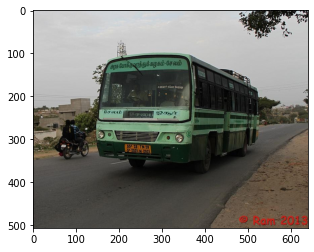

Caption:  a bus traveling on a street near a building
BLEU score: 0.7339350940968121


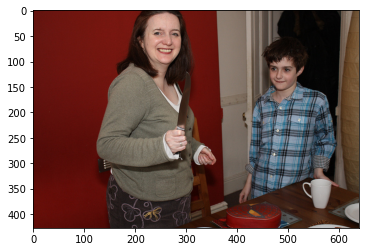

Caption:  a woman is holding a OOV in her hand
BLEU score: 0.6479888925811429


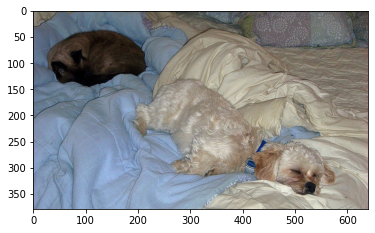

Caption:  a person is holding a toothbrush in his hand
BLEU score: 0.27079322488027685


In [54]:
def show_result(img_index, image_path = test_dir_path):
  pic = list(t_features.keys())[img_index]
  # print(pic[:-4])
  # return
  image = t_features[pic].reshape((1,2048))
  x = plt.imread(test_dir_path+ '/' + pic)
  plt.imshow(x)
  plt.show()
  caption = generate_caption(tokenizer, image, max_length, final_model)
  bleu_score = compute_bleu(pic, caption) 

  print("Caption:", caption)
  print("BLEU score:", bleu_score)

show_result(0)
show_result(10)
show_result(random.randint(0,1000))


# Reinforcement Learning

## Creating Environment

In [55]:
class ICEnv(Env):
  def __init__(self, image, img_id, max_len, num_words, startseq, endseq,
               tokenizer):
    self.prev_rewards = []
    self.reward = 0
    self.total_rewards = 0
    self.max_len = max_len
    self.num_words = num_words
    self.startseq = startseq
    self.endseq = endseq
    self.done = False
    self.img_id = img_id
    self.tokenizer = tokenizer
    self.seq_len = 1

    self.observation_space = {'image': spaces.Box(low = 0, high = 255, 
                                                  shape=(2048,)),
                              "words": spaces.Box(low = 0, high = 2075, 
                                                  shape=(self.max_len,))}

    self.action_space = spaces.Discrete(self.num_words, start = 1)

    self.state = {'image': image, 
                  "words": np.pad([self.startseq], (0, self.max_len -1),
                                  'constant' , constant_values=(0,0))}


    

  def step(self, action):
    info = {}

    """ Might need to change """
    # Update previous reward
    self.prev_rewards.append(self.reward)

    # Apply action
    for i, word in enumerate(self.state['words']):
      if word == 0:
        self.state['words'][i] = action
        self.seq_len += 1
        break

    # Calculate reward
    ind_caption = []
    for word in self.state['words']:
        if word == self.endseq or word == 0:
          break
        elif word == self.startseq:
          continue
        else:
          ind_caption.append(word)

    caption = tokenizer.sequences_to_texts([ind_caption])[0]
    references = train_caps[self.img_id]
    self.reward = compute_bleu(img_id_to_url(self.img_id), caption, False)
    # sentence_bleu(references, caption)
    self.total_rewards += self.reward
    

    # Check if it's done
    if action == self.endseq or self.seq_len == self.max_len:
      self.done = True
    

    return self.state, self.reward, self.done, info

  
  def reset(self, image = None, img_id = None):
    self.prev_rewards = []
    self.reward = 0
    self.total_rewards = 0
    self.done = False
    self.seq_len = 1

    self.state["words"]= np.pad([self.startseq], (0, self.max_len -1),
                                  'constant' , constant_values=(0,0))


    if image != None and img_id != None:
      self.state['image'] = image
      self.img_id = img_id
    
    return self.state

  def render(self, with_image = False):
    if with_image:
      img_path = pictures_dir_path + '/' + img_id_to_url(self.img_id)
      plt.imshow(plt.imread(img_path))
      plt.show()

    ind_caption = []
    for word in self.state['words']:
      if word == 0:
        break
      else:
        ind_caption.append(word)
    caption = tokenizer.sequences_to_texts([ind_caption])[0]
    print(caption)

In [56]:
tmp_img_id = list(train_caps.keys())[0]
tmp_img = features[img_id_to_url(tmp_img_id)]

env = ICEnv(image= tmp_img, img_id= tmp_img_id, 
            max_len=max_length, num_words=num_words,
            startseq = tokenizer.word_index['startseq'],
            endseq = tokenizer.word_index['endseq'], tokenizer= tokenizer)

In [57]:
env.action_space.sample()

833

In [ ]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    env.render(with_image = True)
    while not done:
        env.render()
        print('state is:',env.state['words'], 'state len is:', len(env.state['words']))
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

# Final Training

Generator model is already pretrained using MLE

## Generating fake samples

In [59]:
"""
For the first time
"""
### Generating fake samples

# fake_captions = {}
# for img_url in tqdm.tqdm(features.keys()):
#   image = features[img_url].reshape((1,2048))

#   fake_cap = generate_caption(tokenizer, image,
#                               max_length, final_model)
  
#   fake_captions[img_url] = fake_cap
### Save the features in the images1 pickle file

# with open("/content/drive/MyDrive/fake_captions.pkl", "wb") as fake_caps_pickle:
#     pickle.dump(fake_captions, fake_caps_pickle)

"""
Fo the other times
"""
  # Loading saved captions
fake_captions = pickle.load(open("/content/drive/MyDrive/fake_captions.pkl", "rb"))

## Pre-training Discriminator

### Creating Discriminator

In [60]:
def create_discriminator():
  img_features = Input(shape=(1,2048,))

  caption = Input(shape=(max_length,))
  embedded_caption = Embedding(num_words, embedding_dim, mask_zero=True)(caption)


  # disc_input = add([img_features, embedded_caption])
  disc_input = tf.concat([img_features, embedded_caption], axis=1)

  disc_lstm = LSTM(512)(disc_input)
  disc_dense = Dense(512, activation='leaky_relu')(disc_lstm)
  disc_dropout = Dropout(0.4)
  outputs = Dense(1, activation='sigmoid')(disc_dense)

  disc_model = Model(inputs=[img_features, caption], outputs=outputs)
  # model.summary()

  return disc_model

In [ ]:
disc = create_discriminator()
# print(disc.layers[2].weights, disc.layers[2].trainable)
disc.layers[2].set_weights(final_model.layers[2].weights)
disc.layers[2].trainable = False
disc.summary()
# print(disc.layers[2].weights, disc.layers[2].trainable)

In [61]:
def load_discriminator():
  disc = tf.keras.models.load_model('/content/drive/MyDrive/Models/Disc_V1.h5')
  return disc

In [62]:
def generate_real_fake_wrong_samples():
    # fake captions
    fake_y = np.zeros((4000,))
    fake_features = []
    fake_caps = []
    for url, caption in fake_captions.items():
      feature = features[url]
      fake_features.append(feature)
      fake_caps.append(caption)

    # real captions
    real_y = np.ones((8000,))
    real_features = []
    real_caps = []
    for img_id in train_caps:
      img_url = img_id_to_url(img_id)
      feature = features[img_url]
      real_features.append(feature)
      real_features.append(feature)
      real_cap1, real_cap2 = random.sample(train_caps[img_id], 2)
      real_caps.append(real_cap1)
      real_caps.append(real_cap2)


    wrong_y = np.zeros((4000,))
    wrong_features = []
    wrong_caps = []
    for img_id in train_caps:
      img_url = img_id_to_url(img_id)
      feature = features[img_url]
      wrong_features.append(feature)

      # Finding another image
      second_feature_sorted = False
      while not second_feature_sorted:
        second_id = random.choice(list(train_caps.keys()))
        if img_id != second_id:
          second_feature_sorted = True
      
      wrong_caps.append(random.choice(train_caps[second_id]))

    disc_features = real_features + fake_features + wrong_features
    disc_caps = real_caps + fake_caps + wrong_caps
    disc_y = np.concatenate((real_y, fake_y, wrong_y), axis = 0)
    return disc_features, disc_caps, disc_y

In [63]:
disc_features, disc_caps, disc_y = generate_real_fake_wrong_samples()
np_disc_features = np.array(disc_features)
np_disc_caps = np.array(disc_caps)

In [64]:
disc_sequences = tokenizer.texts_to_sequences(np_disc_caps)
disc_padded = pad_sequences(disc_sequences, maxlen=max_length)
# np_disc_y = disc_y.reshape(12000,1)
# disc_padded.shape
# np_disc_features.shape
# np_disc_caps.shape
# disc.summary()
print(np_disc_features.shape, disc_padded.shape, disc_y.shape)

(16000, 2048) (16000, 16) (16000,)


In [ ]:
disc.compile(loss = 'binary_crossentropy', 
             optimizer = 'adam',
             metrics = ['accuracy'])
# np_disc_features.reshape([12000,1,2048]).shape
disc.fit(x=[np_disc_features.reshape([16000,1,2048]), disc_padded], y=disc_y.reshape(16000,1), verbose=1, epochs=15, batch_size=16)

Epoch 1/15
1000/1000 [==============================] - 9s 7ms/step - loss: 0.4872 - accuracy: 0.7459
Epoch 2/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4784 - accuracy: 0.7502
Epoch 3/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4772 - accuracy: 0.7493
Epoch 4/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4736 - accuracy: 0.7506
Epoch 5/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4626 - accuracy: 0.7537
Epoch 6/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4398 - accuracy: 0.7672
Epoch 7/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3990 - accuracy: 0.7895
Epoch 8/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3539 - accuracy: 0.8159
Epoch 9/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3076 - accuracy: 0.8354
Epoch 10/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.271

In [65]:
# disc.save('/content/drive/MyDrive/Models/' + 'Disc_V1' + '.h5')
disc = load_discriminator()

## Training GAN

In [66]:
gen = final_model

In [140]:
def post_zero_to_pre(array):
  non_zero = []
  the_len = len(array)
  for num in array:
    if num != 0:
      non_zero.append(num)
  # np_non_zero = np.array(non_zero)
  pre_z = np.zeros(the_len - len(non_zero), dtype=np.int32)
  return np.concatenate((pre_z, np.array(non_zero)), axis =0)

# post_zero_to_pre([1,2,3, 0,0,0,0])

### Sampling and Creating Batches Of Data

In [ ]:
t = [2, 12, 111, 5, 2, 74, 4]
tt = []
for i in range(1, len(t)+1):
    curr_s = np.concatenate(([3]+t[:i], np.zeros((max_length - len(t[:i])-1))), axis=0)
    tt.append(curr_s)
    print(len(curr_s))
print(tt)

In [ ]:
def sample_caption_rl(tokenizer, image, img_id, max_length, gmodel, num_words):
  # Creating env
  env = ICEnv(image= image, img_id= img_id, 
            max_len=max_length, num_words=num_words,
            startseq = tokenizer.word_index['startseq'],
            endseq = tokenizer.word_index['endseq'], tokenizer= tokenizer)
  # Sampling
  state = env.reset()
  done = False
  score = 0 
  env.render(with_image = True)
  actions = []
  caption = 'startseq'
  total_states = []
  while not done:
      # env.render()
      pre_zero_seq = post_zero_to_pre(env.state['words'])

      word_probs = gmodel.predict([np.array(env.state['image']).reshape((1,2048)), 
                                  np.array([pre_zero_seq])],verbose=0)
      
      dist = tfp.distributions.Categorical(probs=word_probs, dtype=tf.float32)
      tf_predicted_index = dist.sample()
      predicted_index = np.array(tf_predicted_index)
      
      new_word = tokenizer.sequences_to_texts([predicted_index])[0]
      caption += ' ' + new_word

      action = tokenizer.word_index[new_word]
      actions.append(action)
      
      # print(env.state['words'])
      
      n_state, reward, done, info = env.step(action)
      
  
  for i in range(1, len(actions)+1):
    curr_state = np.concatenate(([3]+actions[:i-1], np.zeros((max_length - len(actions[:i-1])-1), dtype=np.int32)), axis=0)
    total_states.append({'image':env.state['image'],
                         'words':curr_state})

  return reward, total_states, actions, caption


sample_caption_rl(tokenizer, features['000000338532.jpg'], 338532,\
                  max_length, gen, num_words)


In [285]:
def create_fake_captions_batch(batch_size):
  fake_batch = {}
  total_actions = []
  total_rewards = []
  total_urls = []
  total_states = []
  while len(fake_batch) < batch_size:
    img_id = random.choice(list(train_caps.keys()))
    img_url = img_id_to_url(img_id)
    feature = features[img_url].reshape((1,2048))

    rewards, states, actions, caption = sample_caption_rl(tokenizer, feature, img_id, max_length,
                                gen, num_words)
    total_actions.append(actions)
    total_rewards.append(rewards)
    fake_batch[img_url] = caption
    total_urls.append(img_url)
    total_states.append(states)
  return fake_batch, total_actions, total_rewards, total_urls, total_states

# create_fake_captions_batch(4)


### Calculating Scores

In [114]:
def calculate_p(img_cap_pairs, disc, tokenizer, max_length, batch_size):
  img_urls = list(img_cap_pairs.keys())
  img_features = []
  for url in img_urls:
    feature = features[url]
    img_features.append(feature)

  captions = list(img_cap_pairs.values())

  print(np.array(img_features).shape, np.array(captions).shape)
  # x=[np_disc_features.reshape([16000,1,2048]), disc_padded], y=disc_y.reshape(16000,1)
  np_features = np.array(img_features).reshape(batch_size, 1, 2048)

  sequences = tokenizer.texts_to_sequences(captions)
  padded = pad_sequences(sequences, maxlen=max_length)
  np_padded = np.array(padded)
  
  probs = disc.predict([np_features, np_padded])

  return probs.flatten()
# calculate_p

In [115]:
def calculate_s(img_cap_pairs):
  s_values = []
  for url in img_cap_pairs:
    bleu_score = compute_bleu(url, img_cap_pairs[url], False)
    s_values.append(bleu_score)
  return s_values

# calculate_s(fake_batch)

In [116]:
def calculate_r(p_values, s_values, lambda_val):
  np_p = np.array(p_values)
  np_s = np.array(s_values)

  return lambda_val*np_p + (1-lambda_val)*np_s

calculate_r([1,2,3,4], [0,0,0,0], 0.5)

array([0.5, 1. , 1.5, 2. ])

### Updatin Generator Weights

In [400]:
def calculate_greedy_decoding_reward(img_url, tokenizer, gmodel, max_len, for_training=True):
  if for_training:
    feature = features[img_url]
  else:
    feature = t_features[img_url]
  picture = np.array(feature).reshape((1,2048))
  caption = generate_caption(tokenizer, picture, max_len, gmodel)
  # print(caption)
  return compute_bleu(img_url, caption, not for_training)

# calculate_greedy_decoding_reward('000000540466.jpg', tokenizer, gen, max_length)

In [458]:
def calculate_loss(gmodel, action, reward, probs, img_url, tokenizer, max_len, greedy_reward):
    dist = tfp.distributions.Categorical(probs=probs, dtype=tf.float32)
    log_prob = dist.log_prob(action)
    loss = -log_prob*(reward - greedy_reward)
    if math.isnan(loss):
      print('loss reached nan')
      print(np.min(probs), np.max(probs))
    
    # print('loss is:', np.array(loss))
    return loss 

In [463]:
def update_generator(r_values, batch, actions, states, gmodel, urls, max_len):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  counter = 0
  # loss = -.001
  for current_states, reward, current_actions, img_url in zip(states, r_values, actions, urls):
    counter += 1
    print(f'Sample {counter}/{len(urls)}:')
    greedy_reward = calculate_greedy_decoding_reward(img_url, tokenizer,
                                                       gmodel, max_len)
    for action, state in zip(current_actions, current_states):
      
      with tf.GradientTape() as tape:
        
        pre_zero_seq = post_zero_to_pre(state['words'])

        word_probs = gmodel([np.array(state['image']).reshape((1,2048)), 
                                  np.array([pre_zero_seq])], training = True)

        if np.min(word_probs) == 0:
          # word_probs += 1.1499141e-24
          # print('here')
          break
        
        # print(np.min(word_probs), np.max(word_probs))
        if math.isnan(np.min(word_probs)):
          print(current_actions)
          print(state['words'])
          print('max word prob:', np.max(word_probs))
          print('loss is:', loss)
          print('model reached nan')
          print(action, state)
          return

        loss = calculate_loss(gmodel, action, reward, word_probs, img_url, tokenizer, max_len, greedy_reward)
        
      
      grads = tape.gradient(loss, gmodel.trainable_variables)
      optimizer.apply_gradients(zip(grads, gmodel.trainable_variables))
  return gmodel


In [464]:
gen = tf.keras.models.load_model('/content/drive/MyDrive/Models/final_model_V4.h5')
tpic = np.array(features['000000540466.jpg']).reshape((1,2048))
# generate_caption(tokenizer, tpic, max_length, gen)

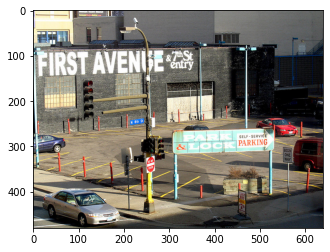

startseq


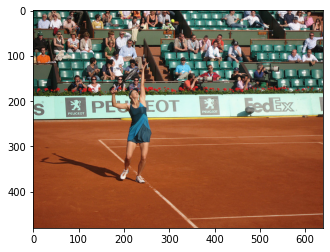

startseq


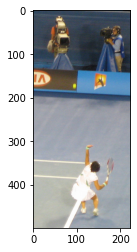

startseq


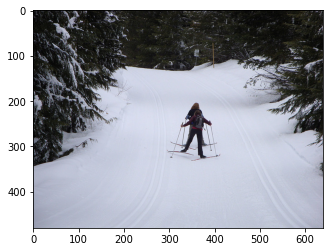

startseq


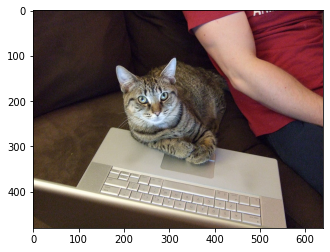

startseq


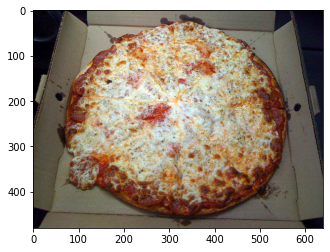

startseq


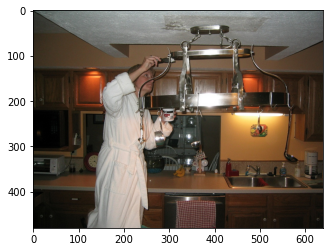

startseq


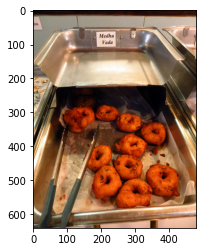

startseq


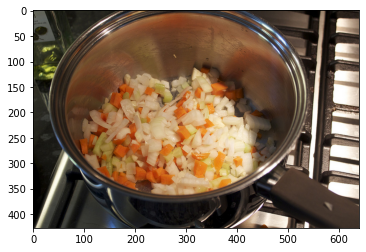

startseq


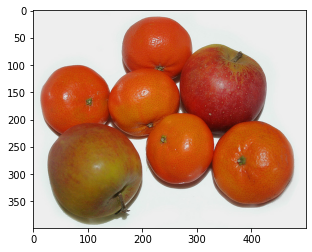

startseq


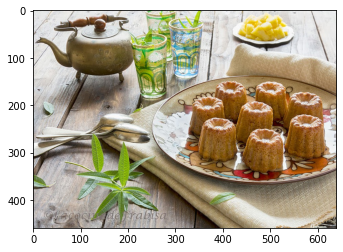

startseq


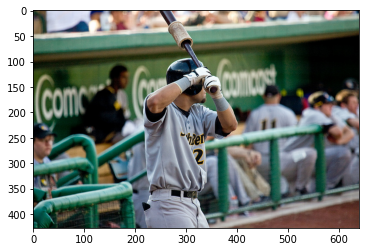

startseq


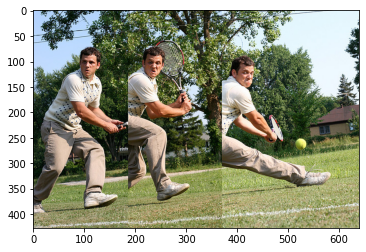

startseq


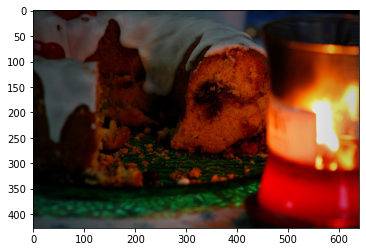

startseq


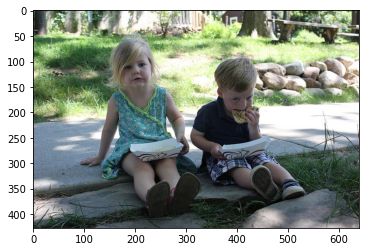

startseq


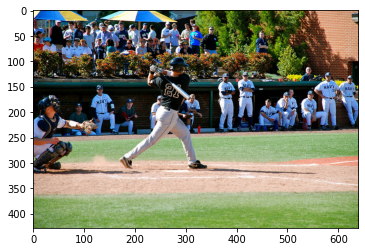

startseq
(16, 2048) (16,)
Sample 1/16:
Sample 2/16:
Sample 3/16:
Sample 4/16:
Sample 5/16:
Sample 6/16:
Sample 7/16:
Sample 8/16:
Sample 9/16:
Sample 10/16:
Sample 11/16:
Sample 12/16:
Sample 13/16:
Sample 14/16:
Sample 15/16:
Sample 16/16:


In [465]:
converged = False
mini_batch = 16
lambda_val = 0.3
while not converged:
  # g part
  fake_batch, actions, rewards, urls, states = create_fake_captions_batch(mini_batch)

  p_values = calculate_p(fake_batch, disc, tokenizer, max_length, mini_batch)
  s_values = calculate_s(fake_batch)
  r_values = calculate_r(p_values, s_values, lambda_val)

  gen2 = update_generator(r_values, fake_batch, actions, states, gen, urls, max_length)
  # d part
  break


In [467]:
def t(img_index):
  pic = list(t_features.keys())[img_index]
    # print(pic[:-4])
    # return
  image = t_features[pic].reshape((1,2048))
  cap = generate_caption(tokenizer, image, max_length, gen)
  # print(calculate_greedy_decoding_reward(pic, tokenizer, gen, max_length, False))
  print(cap)
  print(compute_bleu(pic, cap))
t(0)
t(20)


 a bus traveling on a street near a building
0.7339350940968121
 a man is dressed in a suit and tie
0.4169250595750674


In [447]:
# list(t_features.keys())[20]
test_caps[301061]

['startseq A person is moving green hay towards an elephant that is inside the back of a white truck. endseq',
 'startseq A man pulls an elephant out of a truck. endseq',
 'startseq An elephant in the back of a truck trailer. endseq',
 'startseq An elephant is being fed while in a truck. endseq',
 'startseq There is an elephant in side a truck trying to come out endseq']

# Test blocks

In [233]:
# ta = []
# test = {'words': [3,2,1,4,5,0,0,0,0,6],
#         'a': 's'}
# for i, word in enumerate(test['words']):
#       if word == 0:
#         test['words'][i] = 9
#         break
      # if word == 4 or word == 0:
      #     break
      # elif word == 3:
      #   continue
      # else:
      #   ta.append(word)
# ta
# test
#####################
# tokenizer.sequences_to_texts([[1,2,3,4]])
#####################
# list(train_caps.keys())[0]
# train_caps[308587]
# len(features.keys())
#####################
# tokenizer.word_index['startseq']
# tokenizer.word_index['endseq']
#####################
# len(fake_captions)
#####################
# disc.layers[2].weights
#####################
# arr = [1,2,3,4,5,6]
# arr2 = arr.remove(4)
# print(arr2)
# random.choice(list(train_caps.keys()))
# random.choice(arr.remove(4))
#####################
# arr1 = np.ones((2048,1))
# arr2 = np.zeros((2048, 16))
# np.concatenate((arr1,arr2), axis = 1).shape
#####################
# arr1= [1,2]
# arr2 = [1,3]
# arr1.append(arr2)
# arr1
####################
compute_bleu('000000044590.jpg', 
             'startseq a bike on a street corner with trees in the background endseq',
             False)

0.3476935002176481